In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-bright')

### Loading CSV

Load CSV and set index to datetime

In [2]:
from datetime import datetime

# Only selecting only relevant columns year (1), month (2), day (3), hour (4), pm2.5 (5), dewp (6), temp (7), pres (8), lws (10)
selected_column = ['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']

data = pd.read_csv('Haze.csv', parse_dates = [['year', 'month', 'day', 'hour']],\
                   date_parser = lambda x : datetime.strptime(x, '%Y %m %d %H'),\
                   usecols = selected_column)

# Rename columns
renamed_column = ['time', 'pm2_5', 'dewPoint', 'temp', 'pressure', 'wind_speed']
data.columns = renamed_column

# Set index as time
data.set_index('time', drop = True, inplace = True)

# Drop null value (first day)
data.dropna(axis = 0, inplace = True)

# Resampling to daily basis
data = data.resample('D').interpolate('time')

In [3]:
# Differencing 1 days to remove stationarity and to take the difference in reading
DIFF = 1
ydata = data.diff(periods = DIFF).dropna()

In [4]:
def create_data(timeseries):
    '''
    create_data : 
    
    Args:
        timeseries (numpy array) : 
    Return:
        x (numpy array) :
        y (numpy array) :
    ''' 
    # Squeeze timeseries to 1d array and turn timeseries from numpy array to Series
    timeseries = pd.Series(np.squeeze(timeseries))
    #timeseries = pd.Series(timeseries)
    # Create lookback as the target variable, y
    y = timeseries[LOOKBACK:]
    
    # With each iteration of lag, create its column
    X = pd.DataFrame({'lag'+str(LOOKBACK-i):timeseries.shift(-i) for i in range(0, LOOKBACK)}).dropna().iloc[:-1, :]
    
    return X, y

### LSTM Conditions : 7 lookback windows and 14 days in the testing set

In [5]:
TESTDAYS = 14
LOOKBACK = 7

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features to range between -1 and 1
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(ydata['pm2_5'].values.reshape(-1, 1))

# Create data with 7 days lookback
X, y = create_data(scaled)

# Create a train and test set (30 days)
X_train, X_test = X[ : -TESTDAYS], X[-TESTDAYS : ]
y_train, y_test = y[ : -TESTDAYS], y[-TESTDAYS : ]

# Expand X_train, X_test dimension such that it can become batch_size, timestep (added dimension here), lookback window
X_train = np.expand_dims(X_train, axis = 1)
X_test = np.expand_dims(X_test, axis = 1)

In [7]:
def transform(scaled, org_arr, scaler, test = True):
    '''
    transform: taking the scaled array, apply inverse tranform and un-differencing it
    
    Args:
        scaled (numpy array) : predicted values
        org_arr (Series) : original series
        scaler (object)

    Return:
        result (Series) : overall series
        added (Series) : only transformed series
    '''

    #scaled = scaled[:, 0]
    scaled = scaler.inverse_transform(scaled)
    
    # Remove its dimension such that it is (n, ) and turn it into a Series
    scaled = pd.Series(scaled.squeeze())
    
    if test == True:
        # Adding the differenced array with the unscaled array, this resulting series will contain values from 1 to n
        added = pd.Series(org_arr[-(DIFF + TESTDAYS) : -DIFF].values + scaled)
        
        # Adding the first value of the original array to a new Series
        result = org_arr[: -(TESTDAYS)].append(added)
    else:
        # Adding the differenced array with the unscaled array, this resulting series will contain values from 1 to n
        added = pd.Series(org_arr[LOOKBACK : -(DIFF + TESTDAYS)].values + scaled)
        
        # Adding the first value of the original array to a new Series
        result = org_arr[: (DIFF + LOOKBACK)].append(added)

    # Reset index of result
    result.reset_index(drop = True, inplace = True)
    
    return result, added

### Using a Bidirection LSTM model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, TimeDistributed
from keras.callbacks import  TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [9]:
tensorboard = TensorBoard(log_dir = './logs')
checkpoint = ModelCheckpoint('./checkpoints/bidirection_lstm.hdf5', save_best_only = True)

In [10]:
model = Sequential()
model.add(Bidirectional(LSTM(16, return_sequences = True), input_shape = (1, LOOKBACK), merge_mode= 'ave'))
model.add(Bidirectional(LSTM(16)))
model.add((Dense(1)))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 16)             3072      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(X_train, y_train, batch_size = 1, epochs = 20, \
          callbacks = [checkpoint, tensorboard], validation_data = (X_test, y_test))

Train on 1803 samples, validate on 14 samples
Epoch 1/20
1803/1803 [==============================] - 15s - loss: 0.0437 - val_loss: 0.0741
Epoch 2/20
1803/1803 [==============================] - 11s - loss: 0.0378 - val_loss: 0.0655
Epoch 3/20
1803/1803 [==============================] - 12s - loss: 0.0364 - val_loss: 0.0688
Epoch 4/20
1803/1803 [==============================] - 12s - loss: 0.0355 - val_loss: 0.0727
Epoch 5/20
1803/1803 [==============================] - 11s - loss: 0.0354 - val_loss: 0.0647
Epoch 6/20
1803/1803 [==============================] - 13s - loss: 0.0351 - val_loss: 0.0656
Epoch 7/20
1803/1803 [==============================] - 13s - loss: 0.0352 - val_loss: 0.0676
Epoch 8/20
1803/1803 [==============================] - 13s - loss: 0.0349 - val_loss: 0.0610
Epoch 9/20
1803/1803 [==============================] - 13s - loss: 0.0345 - val_loss: 0.0609
Epoch 10/20
1803/1803 [==============================] - 16s - loss: 0.0348 - val_loss: 0.0651
Epoch 11/20
1

In [12]:
y_pred = model.predict(X_test)

In [13]:
_, predicted = transform(y_pred, data['pm2_5'], scaler)

predicted.index = data['pm2_5'][-TESTDAYS:].index

predicted

time
2014-12-18     56.976887
2014-12-19    151.284893
2014-12-20    184.744453
2014-12-21     54.368378
2014-12-22     56.061470
2014-12-23     94.584183
2014-12-24    138.076070
2014-12-25     47.258583
2014-12-26     66.971485
2014-12-27    115.968491
2014-12-28    142.868317
2014-12-29    241.349319
2014-12-30    238.433678
2014-12-31    210.084446
Freq: D, dtype: float64

In [14]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(data['pm2_5'][-TESTDAYS:].values, predicted))
rmse

119.76545994846884

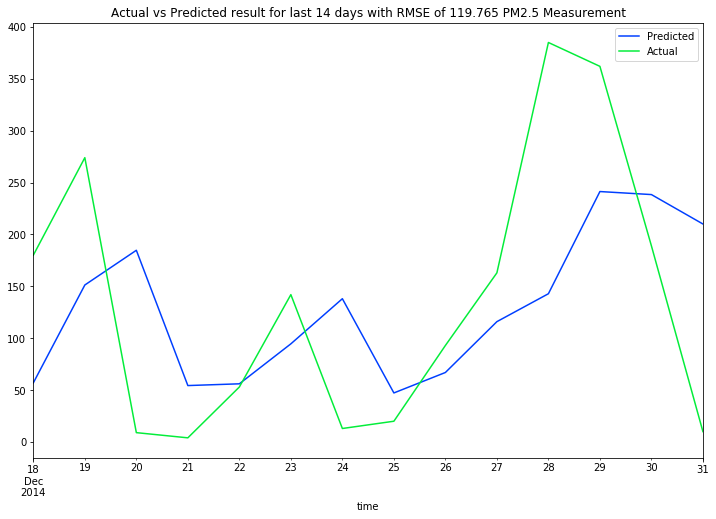

In [15]:
plt.figure(figsize = (12, 8))
plt.title('Actual vs Predicted result for last 14 days with RMSE of {:.3f} PM2.5 Measurement'.format(rmse))
predicted.plot(label = 'Predicted')
data['pm2_5'][-TESTDAYS:].plot(label = 'Actual')
plt.legend(loc = 'best')